In [1]:
#1
import os
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


In [ ]:
#2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#3

CSV_FILE = "/content/drive/MyDrive/data_ml_project/fer2013new.csv"
IMAGE_FOLDER = "/content/drive/MyDrive/data_ml_project/allimage"
IMAGE_SIZE = (224, 224)  # Resizing all images to 224x224
BATCH_SIZE = 32


load csv file

In [ ]:
#4
data = pd.read_csv(CSV_FILE)
print(data.head())
print(data.shape)

      Usage      Image name  neutral  happiness  surprise  sadness  anger  \
0  Training  fer0000000.png        4          0         0        1      3   
1  Training  fer0000001.png        6          0         1        1      0   
2  Training  fer0000002.png        5          0         0        3      1   
3  Training  fer0000003.png        4          0         0        4      1   
4  Training  fer0000004.png        9          0         0        1      0   

   disgust  fear  contempt  unknown  NF  
0        2     0         0        0   0  
1        0     0         0        2   0  
2        0     0         0        1   0  
3        0     0         0        1   0  
4        0     0         0        0   0  
(35887, 12)


In [ ]:
#5
print(data["Image name"].isna().sum())  # Count NaN values
print(data["Image name"].head())

data = data.dropna(subset=["Image name"])
print(data.shape)

173
0    fer0000000.png
1    fer0000001.png
2    fer0000002.png
3    fer0000003.png
4    fer0000004.png
Name: Image name, dtype: object
(35714, 12)


In [ ]:
#6
image_paths = [os.path.join(IMAGE_FOLDER, fname) for fname in data["Image name"]]


In [ ]:
#7 labels
labels = data.iloc[:, 2:].values
print(labels[:5])

[[4 0 0 1 3 2 0 0 0 0]
 [6 0 1 1 0 0 0 0 2 0]
 [5 0 0 3 1 0 0 0 1 0]
 [4 0 0 4 1 0 0 0 1 0]
 [9 0 0 1 0 0 0 0 0 0]]


divide into train , validation and test set


In [ ]:
#8
#Filter the data based on the 'Usage' column
train_data = data[data["Usage"] == "Training"]
val_data = data[data["Usage"] == "PublicTest"]
test_data = data[data["Usage"] == "PrivateTest"]


train_paths = [os.path.join(IMAGE_FOLDER, fname) for fname in train_data["Image name"]]
train_labels = train_data.iloc[:, 2:].values

val_paths = [os.path.join(IMAGE_FOLDER, fname) for fname in val_data["Image name"]]
val_labels = val_data.iloc[:, 2:].values

test_paths = [os.path.join(IMAGE_FOLDER, fname) for fname in test_data["Image name"]]
test_labels = test_data.iloc[:, 2:].values


print(f"Number of training samples: {len(train_paths)}")
print(f"Number of validation samples: {len(val_paths)}")
print(f"Number of testing samples: {len(test_paths)}")


Number of training samples: 28561
Number of validation samples: 3579
Number of testing samples: 3574


In [ ]:
#9
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape=(224, 224, 3), num_outputs=3):
    """
    Builds a CNN model for classifying intensity levels.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_outputs, activation='softmax')  # 3 intensity levels
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
#10
# List of emotions
emotions = ['neutral', 'happiness', 'surprise', 'sadness',
            'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']

# Initialize models for each emotion
emotion_models = {emotion: build_model() for emotion in emotions}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


preprocessing of images

In [ ]:
#11
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import cv2

# Define emotions and intensity labels
EMOTIONS = ['neutral', 'happiness', 'surprise', 'sadness', 'anger',
            'disgust', 'fear', 'contempt', 'unknown', 'NF']
INTENSITY_LABELS = ['low', 'medium', 'high']

def preprocess_image(image_path, label, target_size=(224, 224)):
    """
    Preprocess a single image by resizing and normalizing.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not read image at path: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size) / 255.0
        return image, label
    except Exception as e:
        print(f"Skipping image {image_path}: {e}")
        return None, None

def one_hot_encode_with_labels(label):
    """
    One-hot encode intensity labels and create corresponding feature names.
    """
    one_hot_encoded = []
    feature_names = []

    for emotion, intensity in zip(EMOTIONS, label):
        if 0 <= intensity <= 3:
            one_hot_encoded.extend([1, 0, 0])  # Low
            feature_names.extend([f"{emotion}_low", f"{emotion}_medium", f"{emotion}_high"])
        elif 4 <= intensity <= 6:
            one_hot_encoded.extend([0, 1, 0])  # Medium
            feature_names.extend([f"{emotion}_low", f"{emotion}_medium", f"{emotion}_high"])
        elif 7 <= intensity <= 10:
            one_hot_encoded.extend([0, 0, 1])  # High
            feature_names.extend([f"{emotion}_low", f"{emotion}_medium", f"{emotion}_high"])
        else:
            raise ValueError(f"Invalid intensity value: {intensity}")

    return np.array(one_hot_encoded), feature_names

def preprocess_images_batch_parallel(image_paths, labels, batch_size=100, target_size=(224, 224)):
    """
    Preprocess images in batches and one-hot encode labels with emotion-intensity names.
    """
    all_feature_names = None  # To store feature names

    for start in range(0, len(image_paths), batch_size):
        end = min(start + batch_size, len(image_paths))
        batch_paths = image_paths[start:end]
        batch_labels = labels[start:end]

        with ThreadPoolExecutor() as executor:
            results = list(executor.map(preprocess_image, batch_paths, batch_labels, [target_size]*len(batch_paths)))

        batch_images = [r[0] for r in results if r[0] is not None]
        processed_labels = [one_hot_encode_with_labels(r[1]) for r in results if r[1] is not None]

        # Separate one-hot encoded values and feature names
        batch_labels = np.array([r[0] for r in processed_labels])
        if all_feature_names is None:
            all_feature_names = processed_labels[0][1]

        yield np.array(batch_images), batch_labels, all_feature_names


In [ ]:
#12
import matplotlib.pyplot as plt
import numpy as np


emotion_accuracies = {emotion: [] for emotion in emotion_models.keys()}

for batch_images, batch_labels, feature_names in preprocess_images_batch_parallel(train_paths, train_labels, batch_size=200):

    for emotion, model in emotion_models.items():

        intensity_indices = [
            i for i, name in enumerate(feature_names) if name.startswith(emotion)
        ]


        intensity_labels = batch_labels[:, intensity_indices]


        print(f"Emotion: {emotion}, Intensity Labels Shape: {intensity_labels.shape}")
        print(intensity_labels[:5])


        assert intensity_labels.shape[1] == 3, f"Expected 3 intensity levels, got {intensity_labels.shape[1]}"
        assert batch_images.shape[0] == intensity_labels.shape[0], "Mismatch in batch size between images and labels"


        history = model.fit(batch_images, intensity_labels, epochs=10, verbose=0)


        batch_accuracy = history.history['accuracy'][0]


        emotion_accuracies[emotion].append(batch_accuracy)
        print(f"Emotion: {emotion}, Batch Accuracy: {batch_accuracy}")



Streaming output truncated to the last 5000 lines.
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]
Emotion: neutral, Batch Accuracy: 0.5808081030845642
Emotion: happiness, Intensity Labels Shape: (198, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
Emotion: happiness, Batch Accuracy: 0.7676767706871033
Emotion: surprise, Intensity Labels Shape: (198, 3)
[[0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]]
Emotion: surprise, Batch Accuracy: 0.868686854839325
Emotion: sadness, Intensity Labels Shape: (198, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
Emotion: sadness, Batch Accuracy: 0.8585858345031738
Emotion: anger, Intensity Labels Shape: (198, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
Emotion: anger, Batch Accuracy: 0.9141414165496826
Emotion: disgust, Intensity Labels Shape: (198, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
Emotion: disgust, Batch Accuracy: 0.9898989796638489
Emotion: fear, Intensity Labels Shape: (198, 3)
[[0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
Emoti

In [ ]:
#13
print(f"Validation Test")
for batch_images, batch_labels, feature_names in preprocess_images_batch_parallel(val_paths, val_labels, batch_size=200):

    for emotion, model in emotion_models.items():

        intensity_indices = [
            i for i, name in enumerate(feature_names) if name.startswith(emotion)
        ]


        intensity_labels = batch_labels[:, intensity_indices]


        print(f"Emotion: {emotion}, Intensity Labels Shape: {intensity_labels.shape}")
        print(intensity_labels[:5])


        assert intensity_labels.shape[1] == 3, f"Expected 3 intensity levels, got {intensity_labels.shape[1]}"
        assert batch_images.shape[0] == intensity_labels.shape[0], "Mismatch in batch size between images and labels"


        batch_loss, batch_accuracy = model.evaluate(batch_images, intensity_labels, verbose=0)


        emotion_accuracies[emotion].append(batch_accuracy)
        print(f"Emotion: {emotion}, Batch Accuracy: {batch_accuracy}")
        print(f"Emotion: {emotion}, Batch Loss: {batch_loss}")


Validation Test


NameError: name 'preprocess_images_batch_parallel' is not defined

In [ ]:
print(f"Testing Models on Test Dataset")
test_accuracies = {emotion: [] for emotion in emotion_models.keys()}

for batch_images, batch_labels, feature_names in preprocess_images_batch_parallel(test_paths, test_labels, batch_size=200):

    for emotion, model in emotion_models.items():

        intensity_indices = [
            i for i, name in enumerate(feature_names) if name.startswith(emotion)
        ]


        intensity_labels = batch_labels[:, intensity_indices]


        assert intensity_labels.shape[1] == 3, f"Expected 3 intensity levels, got {intensity_labels.shape[1]}"
        assert batch_images.shape[0] == intensity_labels.shape[0], "Mismatch in batch size between images and labels"


        batch_loss, batch_accuracy = model.evaluate(batch_images, intensity_labels, verbose=0)


        test_accuracies[emotion].append(batch_accuracy)
        print(f"Emotion: {emotion}, Test Batch Accuracy: {batch_accuracy}")
        print(f"Emotion: {emotion}, Test Batch Loss: {batch_loss}")


for emotion, accuracies in test_accuracies.items():
    avg_accuracy = np.mean(accuracies)
    print(f"Emotion: {emotion}, Average Test Accuracy: {avg_accuracy:.2f}")


Testing Models on Test Dataset
Skipping image /content/drive/MyDrive/data_ml_project/allimage/fer0032397.png: Could not read image at path: /content/drive/MyDrive/data_ml_project/allimage/fer0032397.png
Skipping image /content/drive/MyDrive/data_ml_project/allimage/fer0032420.png: Could not read image at path: /content/drive/MyDrive/data_ml_project/allimage/fer0032420.png
Emotion: neutral, Test Batch Accuracy: 0.6161616444587708
Emotion: neutral, Test Batch Loss: 0.8781744241714478
Emotion: happiness, Test Batch Accuracy: 0.7676767706871033
Emotion: happiness, Test Batch Loss: 0.584854781627655
Emotion: surprise, Test Batch Accuracy: 0.8383838534355164
Emotion: surprise, Test Batch Loss: 0.4925125241279602
Emotion: sadness, Test Batch Accuracy: 0.8888888955116272
Emotion: sadness, Test Batch Loss: 0.3969399333000183
Emotion: anger, Test Batch Accuracy: 0.8989899158477783
Emotion: anger, Test Batch Loss: 0.39034587144851685
Emotion: disgust, Test Batch Accuracy: 0.9949495196342468
Emoti

Plotting metrics for emotion: neutral


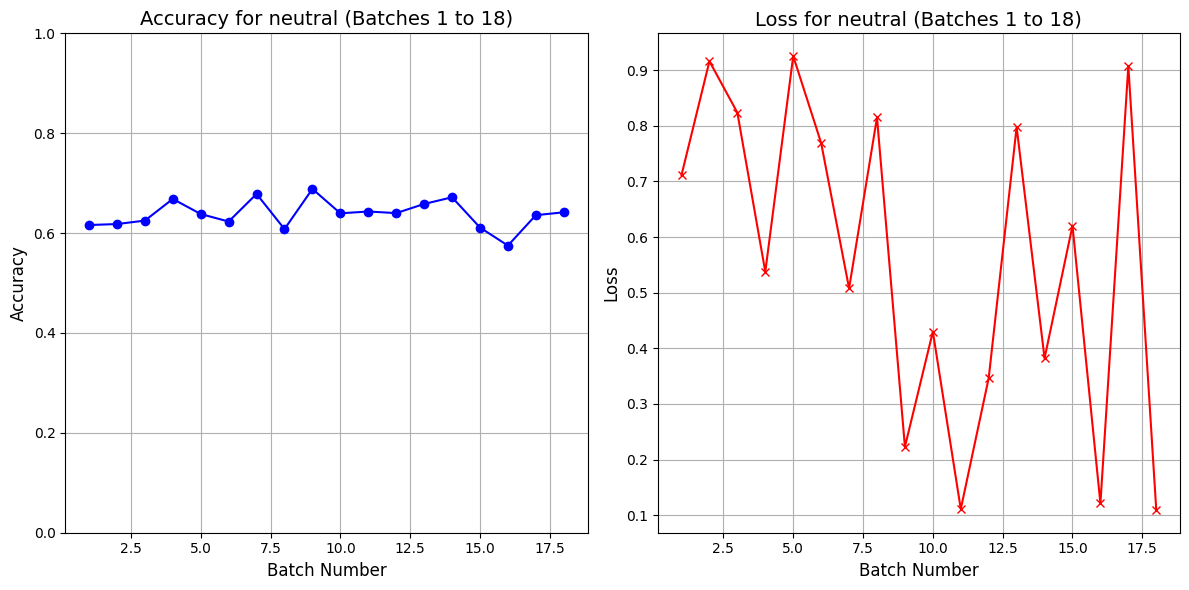

Plotting metrics for emotion: happiness


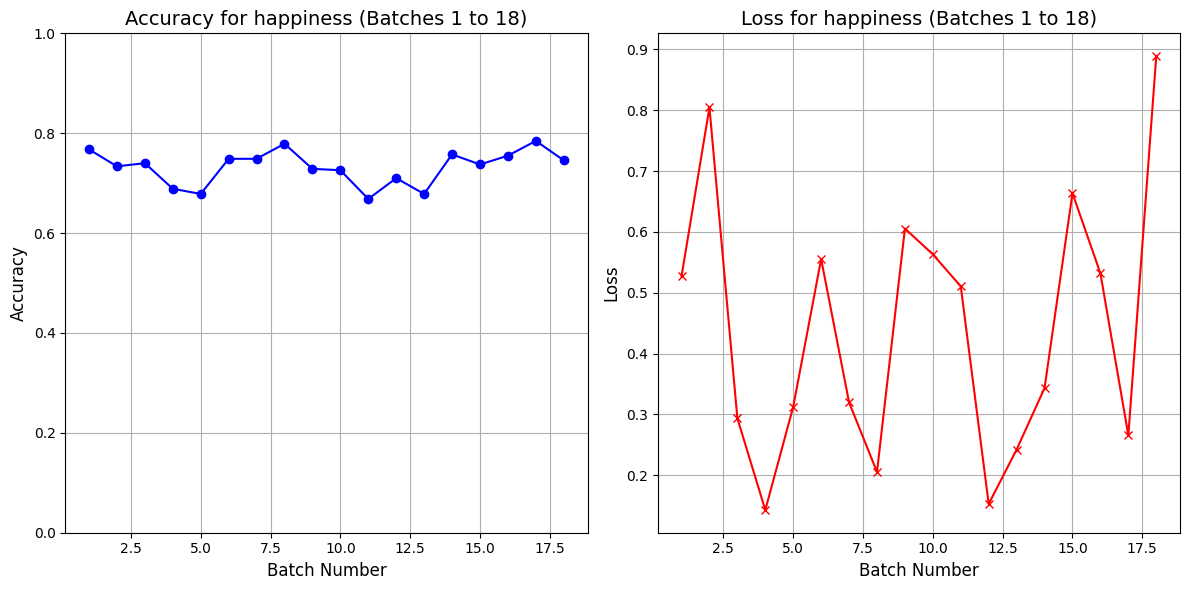

Plotting metrics for emotion: surprise


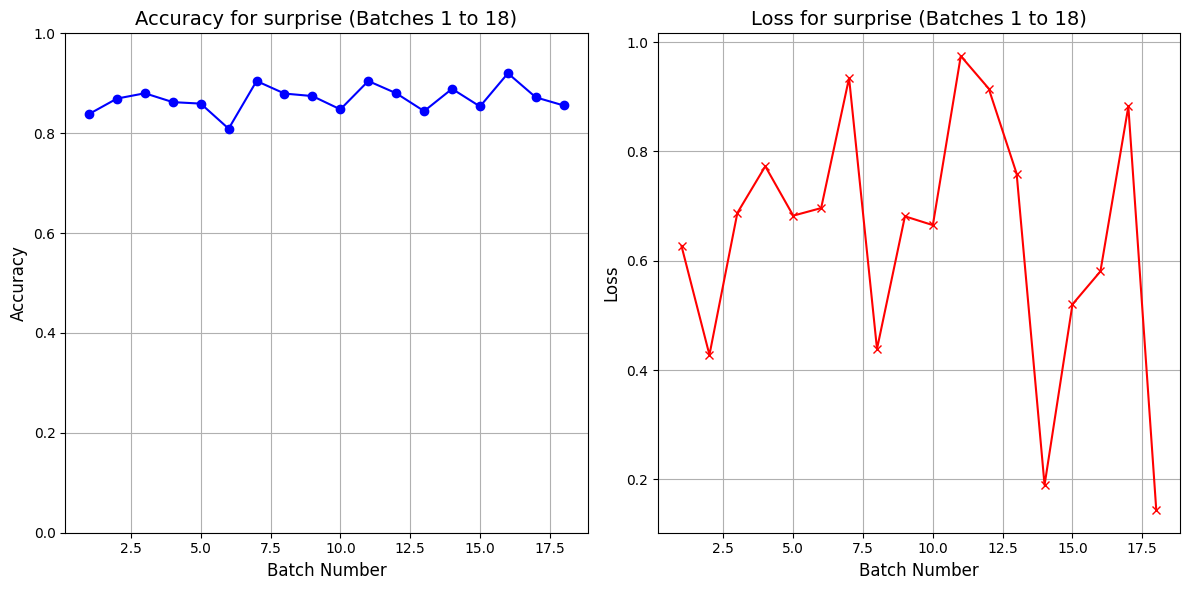

Plotting metrics for emotion: sadness


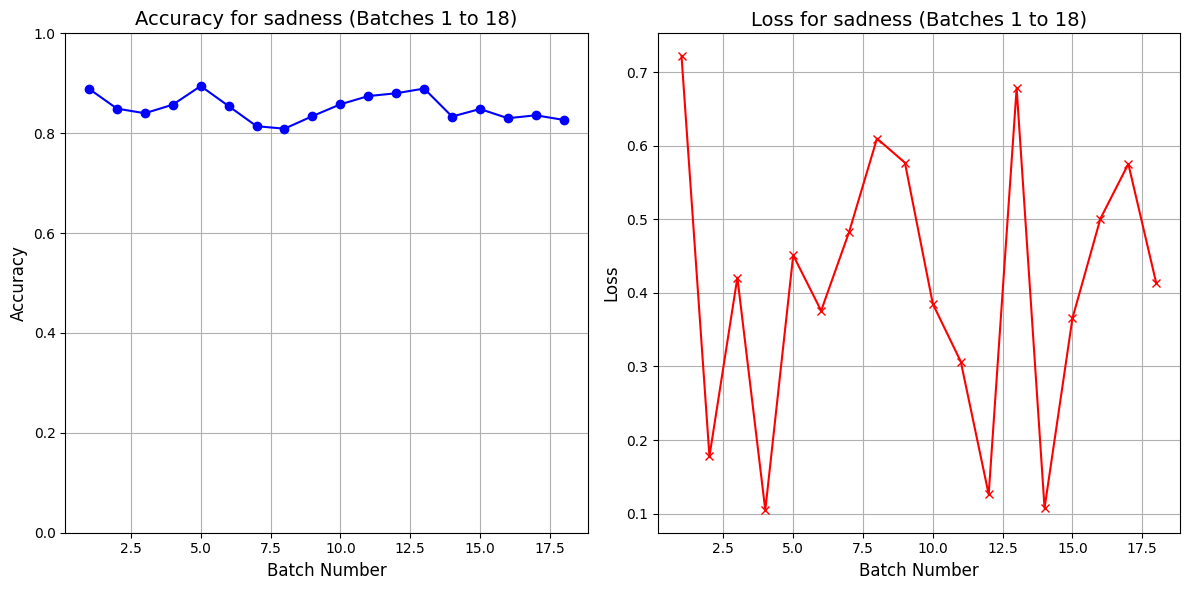

Plotting metrics for emotion: anger


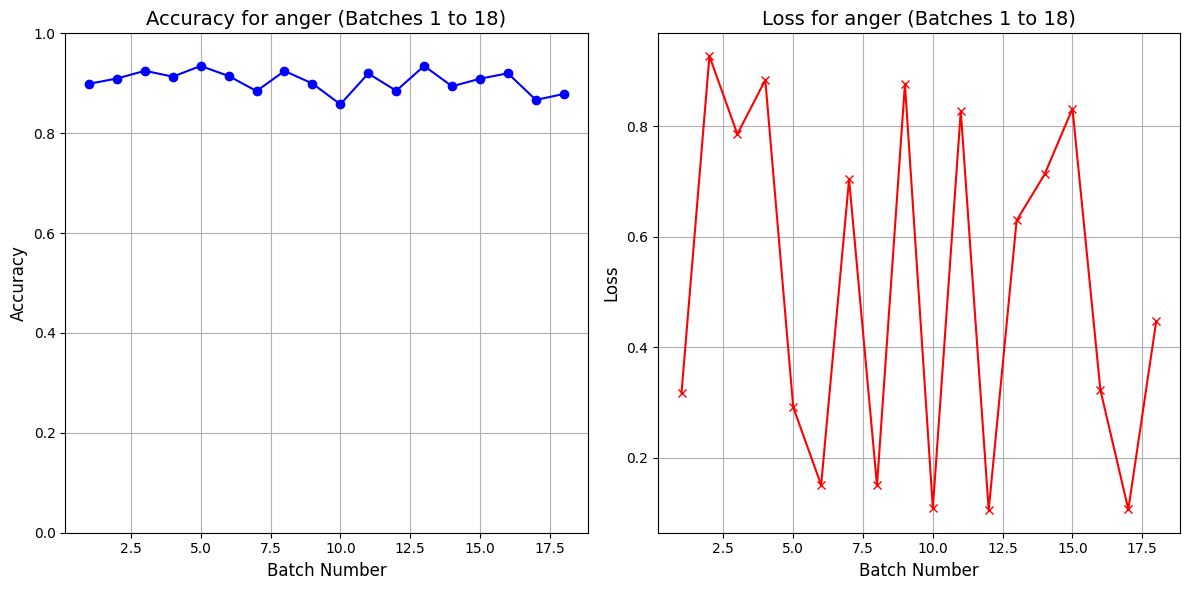

Plotting metrics for emotion: disgust


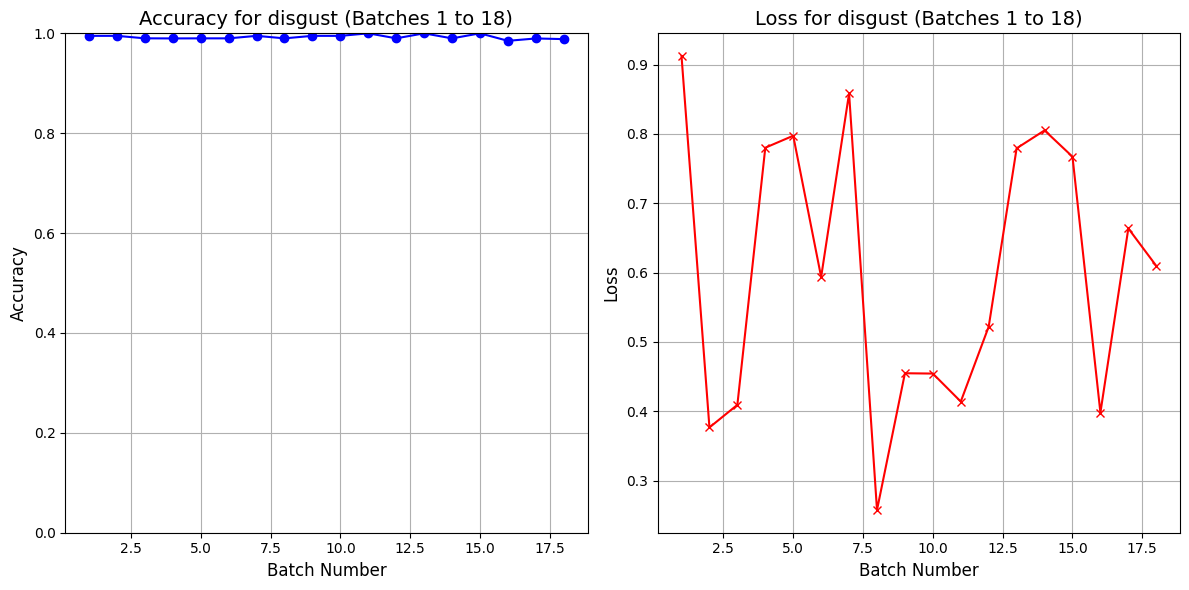

Plotting metrics for emotion: fear


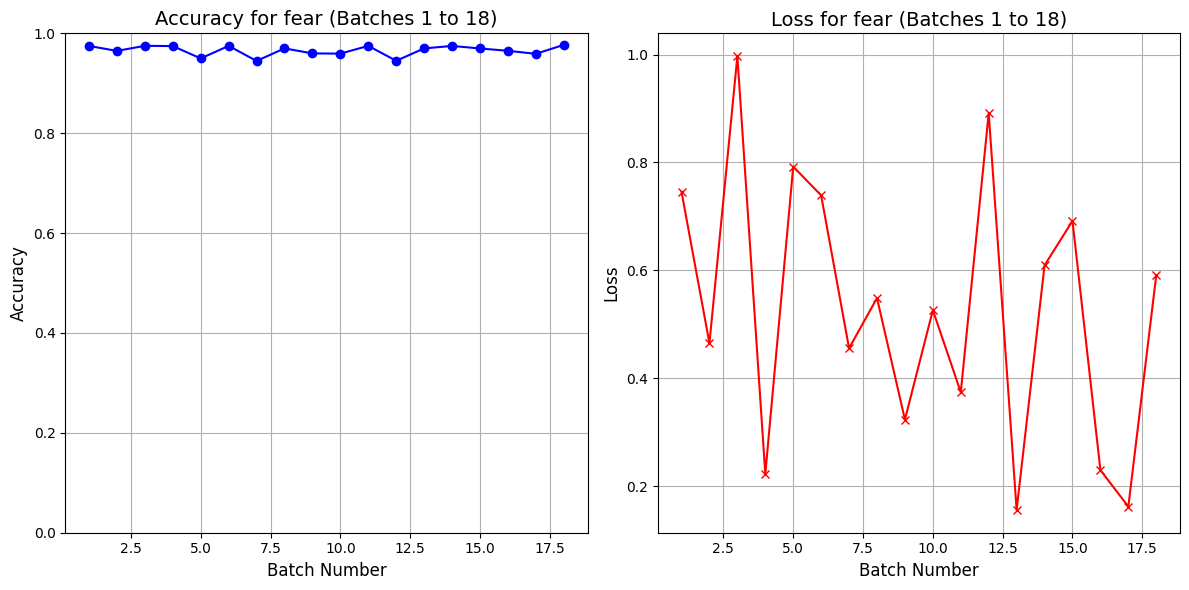

Plotting metrics for emotion: contempt


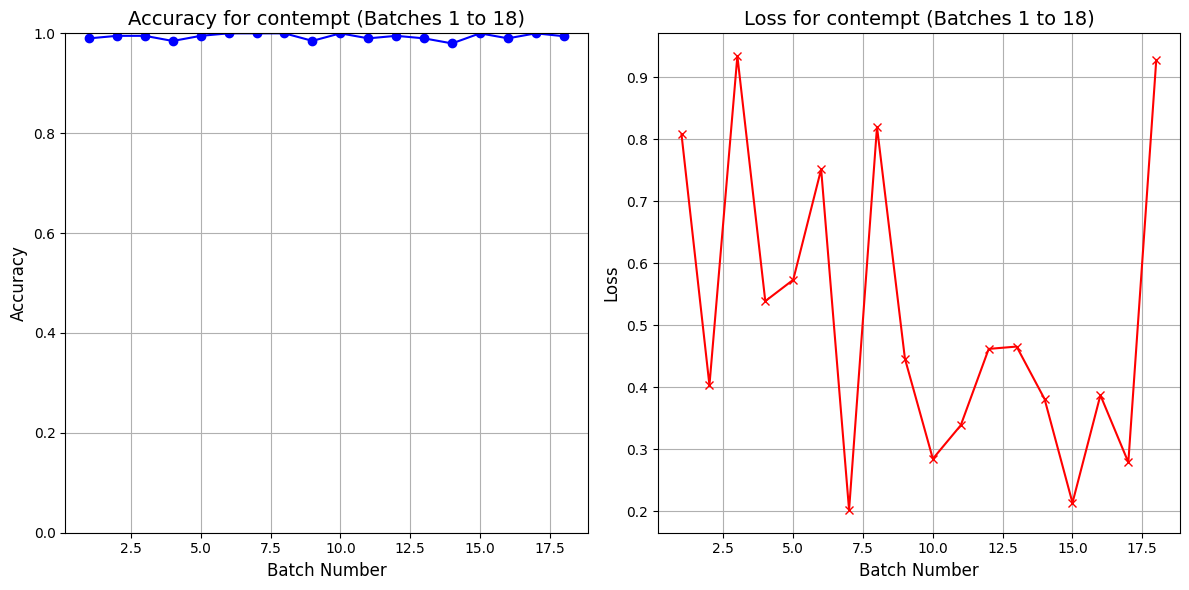

Plotting metrics for emotion: unknown


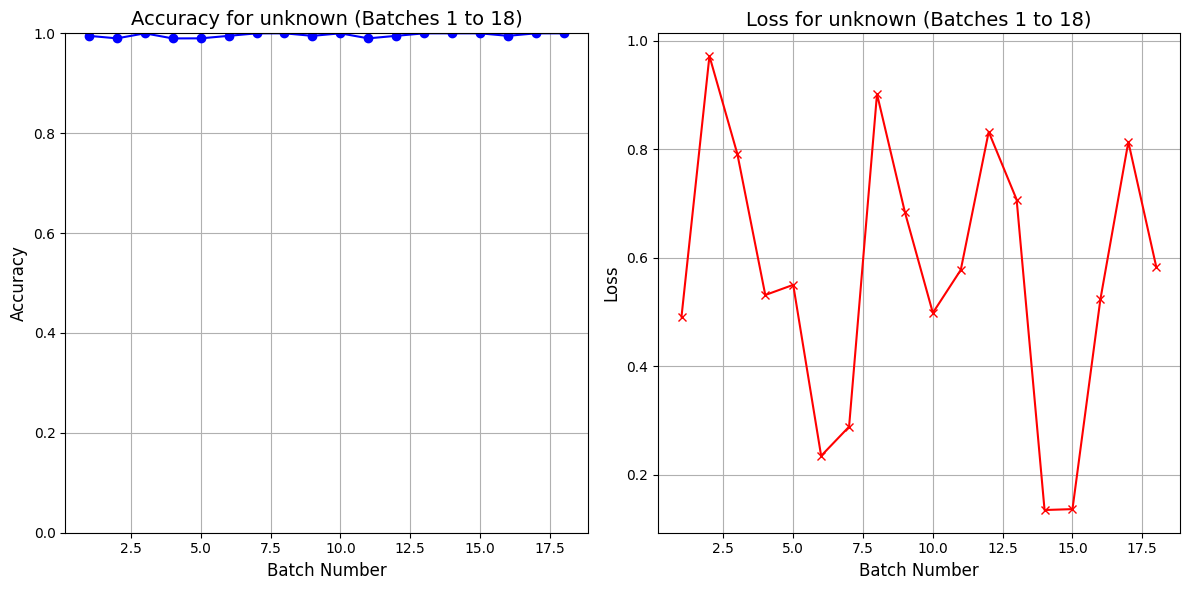

Plotting metrics for emotion: NF


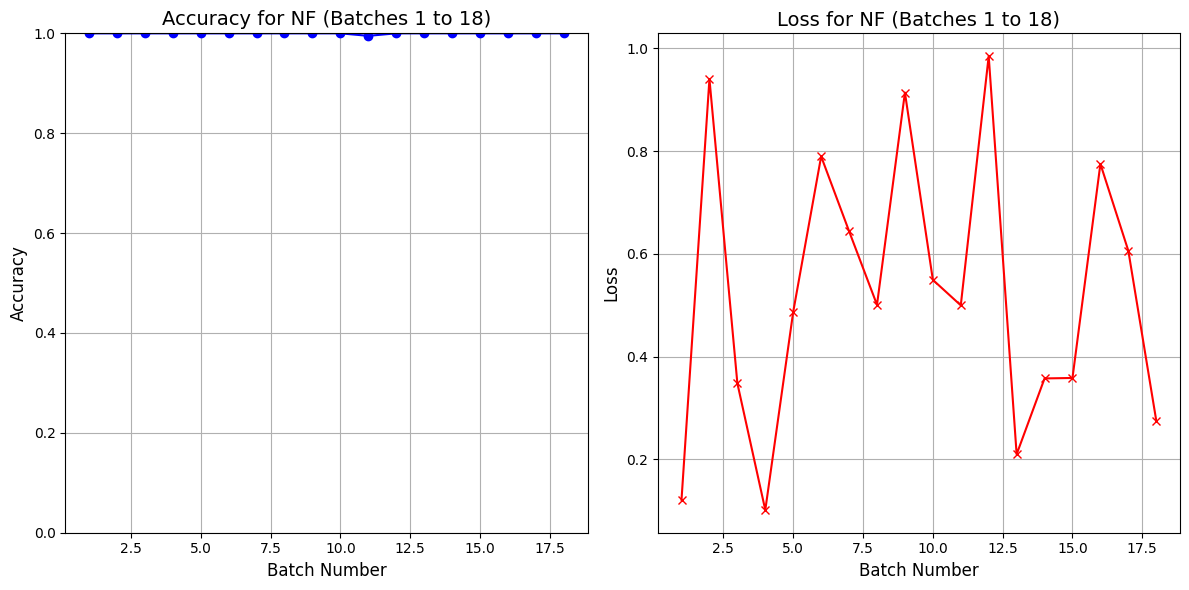

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


test_losses = {emotion: np.random.uniform(0.1, 1.0, size=1000).tolist() for emotion in test_accuracies.keys()}


def plot_emotion_metrics(emotion, accuracies, losses, batch_size=200):
    num_batches = len(accuracies)
    num_groups = (num_batches + batch_size - 1) // batch_size

    for group_idx in range(num_groups):

        start_idx = group_idx * batch_size
        end_idx = min((group_idx + 1) * batch_size, num_batches)


        group_accuracies = accuracies[start_idx:end_idx]
        group_losses = losses[start_idx:end_idx]


        plt.figure(figsize=(12, 6))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(range(start_idx + 1, end_idx + 1), group_accuracies, label=f"Accuracy", color='blue', marker='o')
        plt.title(f"Accuracy for {emotion} (Batches {start_idx + 1} to {end_idx})", fontsize=14)
        plt.xlabel("Batch Number", fontsize=12)
        plt.ylabel("Accuracy", fontsize=12)
        plt.ylim(0, 1)
        plt.grid(True)

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(range(start_idx + 1, end_idx + 1), group_losses, label=f"Loss", color='red', marker='x')
        plt.title(f"Loss for {emotion} (Batches {start_idx + 1} to {end_idx})", fontsize=14)
        plt.xlabel("Batch Number", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.grid(True)

        # Show plots
        plt.tight_layout()
        plt.show()

for emotion in test_accuracies.keys():
    print(f"Plotting metrics for emotion: {emotion}")
    plot_emotion_metrics(
        emotion,
        accuracies=test_accuracies[emotion],
        losses=test_losses[emotion]
    )
